In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io

import woods

In [2]:
config = dict(
    url='https://upload.wikimedia.org/wikipedia/commons/a/a5/Red_Kitten_01.jpg',
)

In [92]:
image = io.imread(config['url'])

Image shape: (2304, 3456, 3)


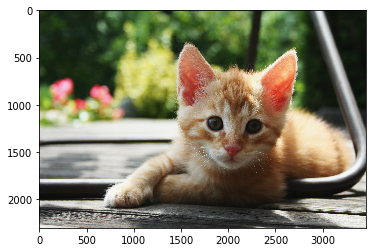

In [93]:
plt.imshow(image)
print("Image shape:", image.shape)

In [94]:
image = image[500:2000, 1500:3000]

In [95]:
shape = image.shape

y = np.arange(shape[0])
x = np.arange(shape[1])
# z = np.arange(shape[2])

# yy, xx, zz = np.meshgrid(y, x, z)
yy, xx = np.meshgrid(y, x)
yy = yy.astype(np.float64) / yy.max()
xx = xx.astype(np.float64) / xx.max()
new_shape = shape[:-1]

In [109]:
# features = np.stack((yy.ravel(), xx.ravel(), zz.ravel()), axis=1).astype(np.float64)
# target = image.ravel().astype(np.float64)

base_features = (yy.ravel(), xx.ravel())
generated_features = []
N = 10
C = N / (2 * np.pi)
for f in base_features:
    for j in range(1, N + 1):
        generated_features.append(np.sin(f * C / j))
        generated_features.append(np.cos(f * C / j))

features = np.stack(generated_features, axis=1).astype(np.float64)
# features = np.stack(base_features, axis=1).astype(np.float64)
target = image[..., 0].flatten().astype(np.float64) / 255.0

In [110]:
features.shape

(2250000, 40)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.99)

In [112]:
%%time

model = woods.GradientBoosting(n_estimators=20, learning_rate=0.25, depth=15)
model.fit(X_train, y_train)

CPU times: user 590 ms, sys: 28.7 ms, total: 618 ms
Wall time: 733 ms


In [113]:
%%time

predictions = model.predict(features)

CPU times: user 6.78 s, sys: 549 ms, total: 7.33 s
Wall time: 7.32 s


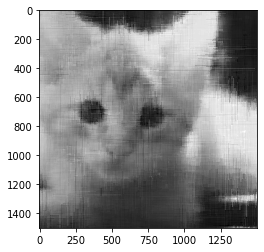

In [114]:
plt.imshow(predictions.reshape(new_shape), cmap='gray')

In [115]:
X_train.shape

(22500, 40)

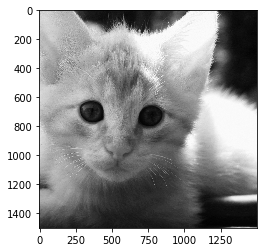

In [103]:
plt.imshow(target.reshape(new_shape), cmap='gray')

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.base import clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import _gb_losses

In [16]:
class SimpleGBM(BaseEstimator, RegressorMixin):
    """ Simple GBM that uses custom base estimators.
    """
    def __init__(self, init_estimator=None, base_estimator=None,
                 n_estimators=100,
                 learning_rate=0.1,
                 loss='ls'):
        self.init_estimator = init_estimator
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.loss = loss
        self.learning_rate = learning_rate
        
    def fit(self, X, y, sample_weight=None):
        if self.init_estimator is None:
            init_estimator = DummyRegressor()
        else:
            init_estimator = clone(self.init_estimator)
        base_estimator = clone(self.base_estimator)
        loss = _gb_losses.LeastSquaresError(n_classes=1)
        self.seq_ = []
        self.gammas_ = []
        
        self.seq_.append(init_estimator.fit(X, y, sample_weight))
        self.gammas_.append(1)
        
        cum_pred = 0 # self.init_estimator.predict(X)
        
        for i in range(self.n_estimators):
            cum_pred += self.gammas_[-1] * self.seq_[-1].predict(X)
            residuals = loss.negative_gradient(y, cum_pred)
            est = clone(base_estimator)
            est.fit(X, residuals)
            self.seq_.append(est)
            self.gammas_.append(self.learning_rate)
            
        return self
    
    def _predict_k(self, X, k=1):
        cum_pred = 0
        for i in range(k):
            cum_pred += self.gammas_[i] * self.seq_[i].predict(X)
        return cum_pred
    
    def predict(self, X):
        return self._predict_k(X, k=len(self.seq_))


class SRGBMRegressor(BaseEstimator, RegressorMixin):
    """ Shallow Randomized GBM Regressor.
    """
    def __init__(self, n_estimators=100, max_depth=1,
                 learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate

    def fit(self, X, y, sample_weight=None):
        dt = DecisionTreeRegressor(max_depth=self.max_depth,
                                   splitter="random")
        self.gbm_ = SimpleGBM(base_estimator=dt,
                              n_estimators=self.n_estimators,
                              learning_rate=self.learning_rate)
        self.gbm_.fit(X, y.ravel(), sample_weight)
        return self

    def predict(self, X):
        return self.gbm_.predict(X)

In [17]:
# %%time

# model2 = SRGBMRegressor(max_depth=15)
# model2.fit(X_train, y_train)

In [18]:
# %%time

# predictions2 = model2.predict(features)

In [19]:
# plt.imshow(predictions2.reshape(new_shape), cmap='gray')

In [20]:
def eval_method_fit(method, iters=5):
    for i in range(iters):
        method.fit(X_train, y_train)
        
def eval_method_predict(method, iters=5):
    for i in range(iters):
        method.predict(X_train)

In [39]:
%%time

m = DecisionTreeRegressor(max_depth=5, splitter='random')
eval_method_fit(m)

CPU times: user 1.94 s, sys: 23.9 ms, total: 1.96 s
Wall time: 2.03 s


In [40]:
%%time

eval_method_predict(m)

CPU times: user 73.4 ms, sys: 8.31 ms, total: 81.7 ms
Wall time: 98.5 ms


In [41]:
%%time

m2 = woods.DecisionTree(depth=5)
eval_method_fit(m2)

CPU times: user 229 ms, sys: 16.3 ms, total: 245 ms
Wall time: 260 ms


In [42]:
%%time

eval_method_predict(m2)

CPU times: user 74.5 ms, sys: 14 ms, total: 88.6 ms
Wall time: 108 ms
